# グラフマイニングの例
- データセット
  - [social circles: Facebook](http://snap.stanford.edu/data/ego-Facebook.html)から facebook_combined.txt.zip を利用。
  - graph1.txt, graph2.txt, graph_modularity_simple.txt: 小さなグラフ例
- ツール等
  - [Graphviz](https://www.graphviz.org/): ノードとエッジで構成されるグラフ描画ツール。
  - [pygraphviz](https://pygraphviz.github.io/): GraphvizをPythonから使うためのラッパー。
  - [networkx](https://networkx.github.io/): ネットワーク解析パッケージ。

## 環境構築

In [1]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

In [2]:
import pandas as pd
import networkx as nx
import pygraphviz
import matplotlib.pyplot as plt

## やや大きめの実データを用いたグラフ化例
- facebook_combined.txt には「どのノード間にエッジがあるか」というリンク情報が保存されている。例えば「0 1」という行なら「ノード0とノード1の間にエッジがある」ことを意味している。
- このままではグラフではないため、データを一度DataFrameとして読み込み、それを from_edges_to_networks() によりグラフに変換する。

### データ準備（facebook_combined.txt）

In [3]:
!curl -O http://snap.stanford.edu/data/facebook_combined.txt.gz
!gzip -d facebook_combined.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  213k  100  213k    0     0   808k      0 --:--:-- --:--:-- --:--:--  808k


In [4]:
!head facebook_combined.txt

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10


In [5]:
filename = "facebook_combined.txt"
df = pd.read_csv(filename, sep=' ')
df[:5]

,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [6]:
# エッジ数の確認（上位10件）

counts = df['0'].value_counts()
counts[:10]

107     1043
1684     778
1912     748
3437     542
0        346
348      225
1941     215
1985     207
483      191
1917     189
Name: 0, dtype: int64

### エッジ集合のDataFrameからグラフに変換

In [7]:
# グラフ変換

def from_edges_to_networks(filename):
    """グラフ読み込み
    Graphvizのラッパーであるpygraphvizにデータを渡すため、
    netoworkx.Graph()へノードとエッジ集合を読み込む。
    """
    G = nx.Graph()
    with open(filename) as fh:
        for line in fh:
            edges = list(map(int, line.split(" ")))
            G.add_edge(edges[0], edges[1])
    return G


G = nx.read_edgelist(filename, nodetype=int)

# ノード数、エッジ数の確認
print(nx.number_of_nodes(G), nx.number_of_edges(G))

4039 88234


### グラフ描画
直接描画することが困難なサイズなので、一度ファイルに保存し、それを縮小したものを描画している。

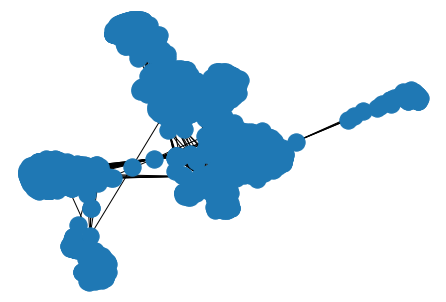

In [8]:
# そのまま描画すると潰れてしまう、、
nx.draw(G)

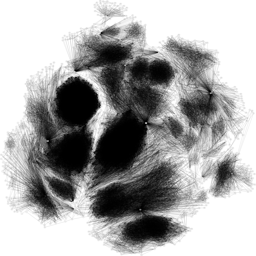

In [9]:
# save graph

pos = nx.nx_agraph.pygraphviz_layout(G, prog='sfdp', args='-Goverlap=false -Tpng -o facebook.png')


from PIL import Image
from IPython.display import display

img = Image.open("facebook.png")
img_resize = img.resize((256,256)) # 画像リサイズ
img_resize.save("facebook_s.png")

with Image.open("facebook_s.png") as im:
  display(im)

### ネットワーク分析例
- エッジ数をカウントし、エッジ数あたりの出現回数を描画。
- 上記をlog-scaleで描画。

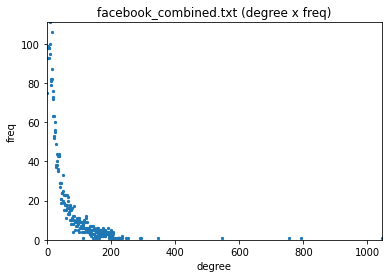

In [10]:
# degree distribution
# normal scale

import collections

# ノード毎に有するエッジ数をカウント
count = []
for index_of_node in G.adj:
    count.append(len(G.adj[index_of_node]))

count.sort()
temp = collections.Counter(count)

# エッジ数あたりの出現回数をカウント
degree, freq = zip(*temp.items())

plt.scatter(degree, freq, s=5)
plt.xlim(0, max(degree))
plt.ylim(0, max(freq))
plt.xlabel('degree')
plt.ylabel('freq')
plt.title(filename + ' (degree x freq)')
plt.show()

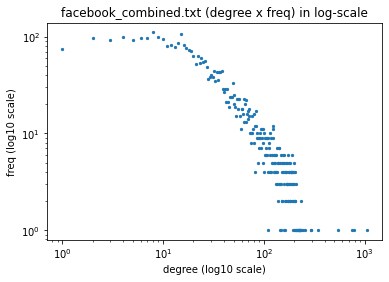

In [11]:
# log scale
plt.scatter(degree, freq, s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree (log10 scale)')
plt.ylabel('freq (log10 scale)')
plt.title(filename + ' (degree x freq) in log-scale')
plt.show()

### Zipfの法則っぽさを確認

In [12]:
zipf_values = []
for i in range(10,50):
  value = i * freq[i]
  zipf_values.append(value)

zipf_values

[810,
 902,
 948,
 1131,
 1484,
 1230,
 1216,
 1241,
 1296,
 1197,
 1040,
 1323,
 1166,
 1380,
 1320,
 1400,
 1274,
 999,
 1064,
 1160,
 1140,
 1364,
 1120,
 1419,
 1224,
 1505,
 1548,
 1628,
 1102,
 1053,
 1160,
 861,
 1218,
 903,
 836,
 1080,
 1104,
 1128,
 1584,
 1225]

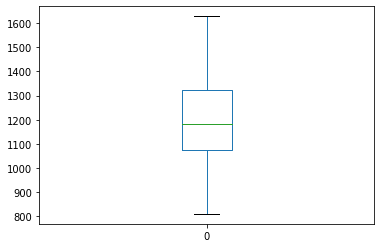

In [13]:
df = pd.DataFrame(zipf_values)
df.plot(kind='box')

## ページランクの例

### データセットの用意

In [14]:
!curl -O https://raw.githubusercontent.com/naltoma/datamining_intro/master/4-casestudy/graph/graph1.txt
!curl -O https://raw.githubusercontent.com/naltoma/datamining_intro/master/4-casestudy/graph/graph2.txt
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    20  100    20    0     0    124      0 --:--:-- --:--:-- --:--:--   124
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   122  100   122    0     0    734      0 --:--:-- --:--:-- --:--:--   734
facebook_combined.txt  facebook_s.png  graph2.txt
facebook.png	       graph1.txt      sample_data


In [15]:
!cat graph1.txt

A B
A C
B C
C A
D C


### ランダムサーファーモデルによるシミュレーション

In [16]:
import random

def random_surfer(G, max_itr=1000, d=0.15):
    """ランダムサーファーモデルのシミュレーション。
    ランダムなノードから出発し、そのページのout-edgesをランダムに選択して移動する。
    ただし、確率dでページ遷移を辞め、無作為にノードを選んで再出発する。

    :param G: networkx.classes.digraph.DiGraph。有向グラフ。
    :param max_itr: ページ遷移回数。
    :param d: エッジ選択から離脱する確率。
    :return: 各ノードの訪問割合。
    """
    num = len(nx.nodes(G))
    nodes = list(nx.nodes(G))
    reached = {}
    count = 0
    current = random.choice(nodes)
    while True:
        if current in reached:
            reached[current] += 1
        else:
            reached.update({current:1})
        count += 1
        if count == max_itr:
            break
        if d < random.random():
            targets = [target for cur, target in nx.edges(G, current)]
            if len(targets) == 0:
                break
            current = random.choice(targets)
        else:
            current = random.choice(nodes)
            continue
        print(count,reached)

    for node in reached.keys():
        reached[node] /= count
    return reached


filename = "graph1.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())
reached = random_surfer(G, 20)
print(reached)

2 {'A': 1, 'D': 1}
3 {'A': 1, 'D': 1, 'C': 1}
4 {'A': 2, 'D': 1, 'C': 1}
5 {'A': 2, 'D': 1, 'C': 1, 'B': 1}
6 {'A': 2, 'D': 1, 'C': 2, 'B': 1}
7 {'A': 3, 'D': 1, 'C': 2, 'B': 1}
8 {'A': 3, 'D': 1, 'C': 2, 'B': 2}
9 {'A': 3, 'D': 1, 'C': 3, 'B': 2}
10 {'A': 4, 'D': 1, 'C': 3, 'B': 2}
11 {'A': 4, 'D': 1, 'C': 4, 'B': 2}
12 {'A': 5, 'D': 1, 'C': 4, 'B': 2}
13 {'A': 5, 'D': 1, 'C': 5, 'B': 2}
15 {'A': 7, 'D': 1, 'C': 5, 'B': 2}
16 {'A': 7, 'D': 1, 'C': 6, 'B': 2}
17 {'A': 8, 'D': 1, 'C': 6, 'B': 2}
18 {'A': 8, 'D': 1, 'C': 7, 'B': 2}
19 {'A': 9, 'D': 1, 'C': 7, 'B': 2}
{'A': 0.45, 'D': 0.05, 'C': 0.35, 'B': 0.15}


### networkx.pagerankによるランク評価

In [17]:
filename = "graph1.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())

# ランク算出
pr = nx.pagerank(G)
print(pr)

{'A': 0.372526246091333, 'B': 0.19582365458881654, 'C': 0.39415009931985023, 'D': 0.037500000000000006}


### グラフ描画

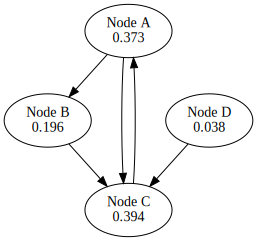

In [18]:
# グラフ描画
pos = nx.spring_layout(G)
labels = {}
for node in pr.keys():
    labels[node] = 'Node {}\n{}'.format(node, round(pr[node], 3))

G = nx.relabel_nodes(G, labels)

import graphviz
graphviz.Source(nx.nx_agraph.to_agraph(G))

## 少し複雑なグラフでページランク確認

{'1': 0.12174896105921995, '2': 0.04386978407256124, '3': 0.04386978407256124, '4': 0.04386978407256124, '5': 0.06530818443477784, '6': 0.10217580762337017, '7': 0.07144359556771177, '8': 0.05279920075611914, '15': 0.14450495559625123, '9': 0.03181526582418545, '10': 0.05885906219895707, '11': 0.02188284889175391, '12': 0.02188284889175391, '13': 0.02188284889175391, '14': 0.02188284889175391, '16': 0.13220421915470792}


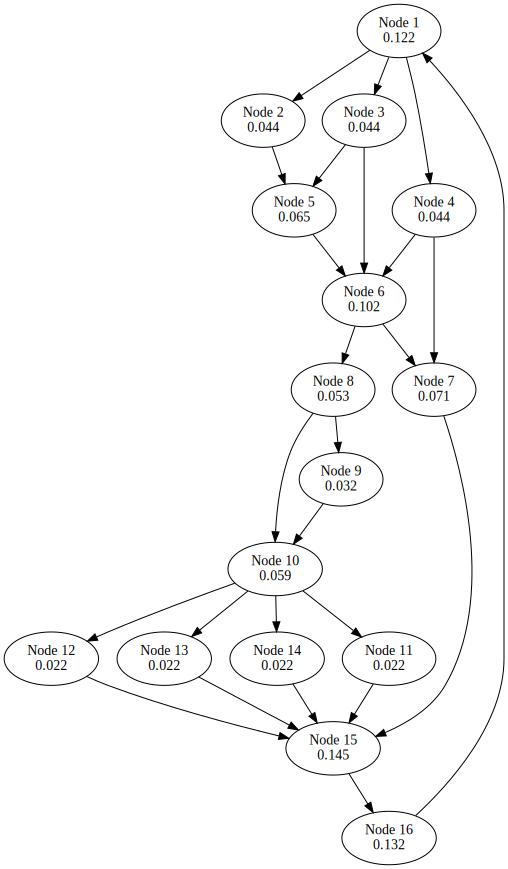

In [19]:
filename = "graph2.txt"
G = nx.read_edgelist(filename, create_using=nx.DiGraph())

# ランク算出
pr = nx.pagerank(G)
print(pr)

# グラフ描画
pos = nx.spring_layout(G)
labels = {}
for node in pr.keys():
    labels[node] = 'Node {}\n{}'.format(node, round(pr[node], 3))

G = nx.relabel_nodes(G, labels)

#nx.nx_agraph.view_pygraphviz(G, prog='sfdp')

import graphviz
graphviz.Source(nx.nx_agraph.to_agraph(G))
#nx.draw_networkx(G)

## モジュラリティの確認

## データセットの用意

In [20]:
!curl -O https://raw.githubusercontent.com/naltoma/datamining_intro/master/4-casestudy/graph/graph_modularity_simple.txt
!head graph_modularity_simple.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    84  100    84    0     0    518      0 --:--:-- --:--:-- --:--:--   521
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


### girvan_newman方式のモジュラリティ評価

(['1', '2', '3', '4', '5'], ['A', 'B', 'C', 'D', 'E'])


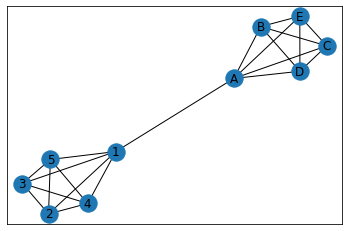

In [21]:
%matplotlib inline
from networkx.algorithms.community.centrality import girvan_newman

filename = "graph_modularity_simple.txt"
G = nx.read_edgelist(filename)

comp = girvan_newman(G)
print(tuple(sorted(c) for c in next(comp)))

#nx.nx_agraph.view_pygraphviz(G, prog='sfdp')
nx.draw_networkx(G)

In [22]:
from networkx import community

clusters = []
clusters.append([{'1', '2', '3', '4', '5'}, {'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'2', '3', '4', '5'}, {'1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'3', '4', '5'}, {'2', '1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'4', '5'}, {'2', '3', '1', 'A', 'B', 'C', 'D', 'E'}])
clusters.append([{'5'}, {'2', '3', '4', '1', 'A', 'B', 'C', 'D', 'E'}])

for i, cluster in enumerate(clusters):
    modularity = community.modularity(G, cluster)
    print('modularity(cluster{}) = {}'.format(i, modularity))

modularity(cluster0) = 0.45238095238095233
modularity(cluster1) = 0.2811791383219955
modularity(cluster2) = 0.12244897959183668
modularity(cluster3) = 0.02267573696145122
modularity(cluster4) = -0.018140589569161043
